In [1]:
%load_ext autoreload
%autoreload 2

# Standard imports
import os
import sys
import random
import json
import pickle as pkl
import numpy as np
import pandas as pd
from collections import defaultdict

# Change to parent directory (where the main project files are located)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(parent_dir)
print(f"Working directory: {os.getcwd()}")

# Add parent directory to path to import project modules
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Project imports from parent directory
from expand_subgraph import ExpandSubgraph
from utils import calculate_statistics
from load_data import DataLoader

# Add coverage_analysis directory to path for local imports
coverage_analysis_dir = os.path.join(parent_dir, 'coverage_analysis')
if coverage_analysis_dir not in sys.path:
    sys.path.insert(0, coverage_analysis_dir)

# Local imports from coverage_analysis directory
from analysis_utils import (
    test_method_on_queries, 
    create_results_table,
    run_complete_analysis
)

print("✅ Libraries loaded successfully")

Working directory: d:\code\research\messing_around\prototype
✅ Libraries loaded successfully


### Original instruction:

+ `train-queries`/`valid-queries`/`test-queries.pkl`: defaultdict(set), each key represents a query structure, and the value represents the instantiated queries  
+ `train-answers.pkl`: defaultdict(set), each key represents a query, and the value represents the answers obtained in the training graph (edges in train.txt)  
+ `valid-easy-answers`/`test-easy-answers.pkl`: defaultdict(set), each key represents a query, and the value represents the answers obtained in the training graph (edges in `train.txt`) / valid graph (edges in `train.txt`+`valid.txt`)  
+ `valid-hard-answers`/`test-hard-answers.pkl`: defaultdict(set), each key represents a query, and the value represents the additional answers obtained in the validation graph (edges in `train.txt`+`valid.txt`) / test graph (edges in `train.txt`+`valid.txt`+`test.txt`)  
### Note
+ valid_easy thì có reasoning path thuộc `train.txt  `
+ valid_hard thì có reasoning path thuộc `val.txt` + `train.txt`

In [9]:
# Configuration class with variable cands_lim
class Config:
    data_path = 'knowledge_graph/KG_data/FB15k-237-betae'
    seed = 1234
    k_rel = 4 # beams
    k_cands = 120
    depth = 8
    gpu = 0
    fact_ratio = 1.0
    val_num = -1
    epoch = 200
    layer = 6
    batchsize = 16
    cpu = 1
    weight = ''
    add_manual_edges = False
    remove_1hop_edges = True
    only_eval = False
    not_shuffle_train = False
    device = "cuda:0"
    
    def __init__(self, cands_lim=1024, fact_ratio=0.75, reset_seed=True):
        self.cands_lim = cands_lim
        self.fact_ratio = fact_ratio
        # Only reset seed if explicitly requested (default behavior preserved for compatibility)
        if reset_seed:
            random.seed(self.seed)
            np.random.seed(self.seed)

print("🔧 Configuration class ready")

🔧 Configuration class ready


In [10]:
# Load data once
print("📚 Loading data...")

# Load query datasets
with open("knowledge_graph/queries/CWQ_sim_queries.pkl", "rb") as f:
    queries = pkl.load(f)


# Initialize base config and data loader
base_config = Config() # dummy config
loader = DataLoader(base_config, mode='train')

loader.shuffle_train()

train_graph = loader.train_graph
train_graph_homo = list(set([(h, t) for (h, r, t) in train_graph]))

base_config.n_ent = loader.n_ent
base_config.n_rel = loader.n_rel



# print(f"🔗 Graph loaded: {len(train_graph)} edges, {base_config.n_ent} entities")
# print("✅ Data loading complete")

📚 Loading data...
==> removing 1-hop links...
==> done
==> removing 1-hop links...
==> done


In [11]:
GoG_args = {
    'drop_ratio': 0.4,
}


sampler = ExpandSubgraph( # dummy sampler
        base_config.n_ent, base_config.n_rel,
        train_graph_homo, train_graph,
        args=base_config,
        GoG_simulation=True,
        GoG_args=GoG_args
)

In [12]:
# Define cands_lim values to test
cands_lim_values = [256, 512, 1024]
drop_ratios_list = [0.4]
num_queries_per_test =  100 # Number of queries to test per query type

print(f"🧪 Testing cands_lim values: {cands_lim_values}")
print(f"📊 Using {num_queries_per_test} queries per query type")

🧪 Testing cands_lim values: [256, 512, 1024]
📊 Using 100 queries per query type


In [13]:
# Run experiments with better error handling
print("🚀 Starting experiments...\n")

results = []

# Set seed once at the beginning to ensure reproducibility
# but don't reset it for each config to get different query shuffles

for j, drop_ratio in enumerate(drop_ratios_list):
    for i, cands_lim in enumerate(cands_lim_values):
        print(f"🔬 Testing cands_lim = {cands_lim}, drop_ratio = {drop_ratio}, ({i+1}/{len(cands_lim_values)})")
        
            # Create config with specific cands_lim but don't reset random seed
        config = Config(cands_lim=cands_lim, fact_ratio=1.0)


        GoG_args = {
            'drop_ratio': drop_ratio,
        }


        sampler = ExpandSubgraph( # dummy sampler
                base_config.n_ent, base_config.n_rel,
                train_graph_homo, train_graph,
                args=config,
                GoG_simulation=True,
                GoG_args=GoG_args
        )
        test_queries = queries[:num_queries_per_test]
        # print(f"Testing queries: {test_queries}")
        metrics = test_method_on_queries(test_queries, sampler, 'defaut')
        
        # Store results
        result = {
            'drop_ratio': drop_ratio,
            'cands_lim': cands_lim,
            'mean_coverage': metrics['mean_coverage'],
            'hit_rate': metrics['hit_rate'],
            'avg_subgraph_size': metrics['avg_subgraph_size'],
            'num_queries': metrics['num_queries'],
            'skip_queries': metrics['skipped_queries']
        }
        results.append(result)
        
        print(f"coverage: {metrics['mean_coverage']:.4f}, Hit: {metrics['hit_rate']:.4f}")
            
        
        

print("✅ Experiments completed!")
print(f"📊 Collected {len(results)} results")

🚀 Starting experiments...

🔬 Testing cands_lim = 256, drop_ratio = 0.4, (1/3)

     ⚠️ Skipping query 18 due to empty subgraph.

     ⚠️ Skipping query 48 due to empty subgraph.
coverage: 0.6531, Hit: 0.6531
🔬 Testing cands_lim = 512, drop_ratio = 0.4, (2/3)

     ⚠️ Skipping query 18 due to empty subgraph.

     ⚠️ Skipping query 48 due to empty subgraph.
coverage: 0.6939, Hit: 0.6939
🔬 Testing cands_lim = 1024, drop_ratio = 0.4, (3/3)

     ⚠️ Skipping query 18 due to empty subgraph.

     ⚠️ Skipping query 48 due to empty subgraph.
coverage: 0.7551, Hit: 0.7551
✅ Experiments completed!
📊 Collected 3 results


In [14]:
results

[{'drop_ratio': 0.4,
  'cands_lim': 256,
  'mean_coverage': 0.6530612244897959,
  'hit_rate': 0.6530612244897959,
  'avg_subgraph_size': np.float64(256.0),
  'num_queries': 98,
  'skip_queries': [17, 47]},
 {'drop_ratio': 0.4,
  'cands_lim': 512,
  'mean_coverage': 0.6938775510204082,
  'hit_rate': 0.6938775510204082,
  'avg_subgraph_size': np.float64(512.0),
  'num_queries': 98,
  'skip_queries': [17, 47]},
 {'drop_ratio': 0.4,
  'cands_lim': 1024,
  'mean_coverage': 0.7551020408163265,
  'hit_rate': 0.7551020408163265,
  'avg_subgraph_size': np.float64(1014.2448979591836),
  'num_queries': 98,
  'skip_queries': [17, 47]}]

In [ ]:
# Create results DataFrame
results_df = pd.DataFrame(results)
print("📊 Results Summary:")
print(results_df.round(4).head())

📊 Results Summary:
   drop_ratio  cands_lim  mean_coverage  hit_rate  avg_subgraph_size  \
0         0.4       2048         0.6875    0.6875             1024.0   

   num_queries  
0           48  


In [ ]:
# Create detailed results table
create_results_table(results_df)


📊 CANDIDATES LIMIT PERFORMANCE COMPARISON
⚠️ Error creating pivot table: 'query_type'

📊 Raw Results Summary:
 fact_ratio  cands_lim  mean_coverage  hit_rate  avg_subgraph_size  num_queries
        0.4        512            0.0       0.0           999.5625           48
        0.4       1024            0.0       0.0           999.5625           48
        0.4       2048            0.0       0.0           999.5625           48
        0.6        512            0.0       0.0           999.5625           48
        0.6       1024            0.0       0.0           999.5625           48
        0.6       2048            0.0       0.0           999.5625           48
        0.8        512            0.0       0.0           999.5625           48
        0.8       1024            0.0       0.0           999.5625           48
        0.8       2048            0.0       0.0           999.5625           48


,fact_ratio,cands_lim,mean_coverage,hit_rate,avg_subgraph_size,num_queries
0,0.4,512,0.0,0.0,999.5625,48
1,0.4,1024,0.0,0.0,999.5625,48
2,0.4,2048,0.0,0.0,999.5625,48
3,0.6,512,0.0,0.0,999.5625,48
4,0.6,1024,0.0,0.0,999.5625,48
5,0.6,2048,0.0,0.0,999.5625,48
6,0.8,512,0.0,0.0,999.5625,48
7,0.8,1024,0.0,0.0,999.5625,48
8,0.8,2048,0.0,0.0,999.5625,48


In [ ]:
a

In [ ]:
# Save results
print("💾 Saving results...")

# Save to JSON
results_dict = {
    'experiment_type': 'cands_lim_analysis',
    'cands_lim_values': cands_lim_values,
    'num_queries_per_test': num_queries_per_test,
    'results': results
}

with open('results/expand_subgraph/cands_lim_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)

# Save DataFrame to CSV
results_df.to_csv('results/expand_subgraph/cands_lim_results.csv', index=False)

print("✅ Results saved to:")
print("   📄 results/expand_subgraph/cands_lim_results.json")
print("   📄 results/expand_subgraph/cands_lim_results.csv")
print("   🖼️  results/expand_subgraph/cands_lim_analysis.png")

💾 Saving results...
✅ Results saved to:
   📄 results/expand_subgraph/cands_lim_results.json
   📄 results/expand_subgraph/cands_lim_results.csv
   🖼️  results/expand_subgraph/cands_lim_analysis.png


🔍 Loading experimental results...
✅ Loaded 45 experimental results
   Columns: ['fact_ratio', 'cands_lim', 'query_type', 'mean_coverage', 'hit_rate', 'avg_subgraph_size', 'num_queries']
   Fact ratios tested: [np.float64(0.4), np.float64(0.6), np.float64(0.8)]
   Candidates limits tested: [np.int64(64), np.int64(128), np.int64(256), np.int64(512), np.int64(1024)]
   Query types: ['1_hop', '2_hop', '3_hop']

🎨 GENERATING VISUALIZATION PLOTS...

📊 Creating comprehensive fact_ratio & cands_lim analysis...
📊 Plot saved to: results/expand_subgraph/comprehensive_analysis.png


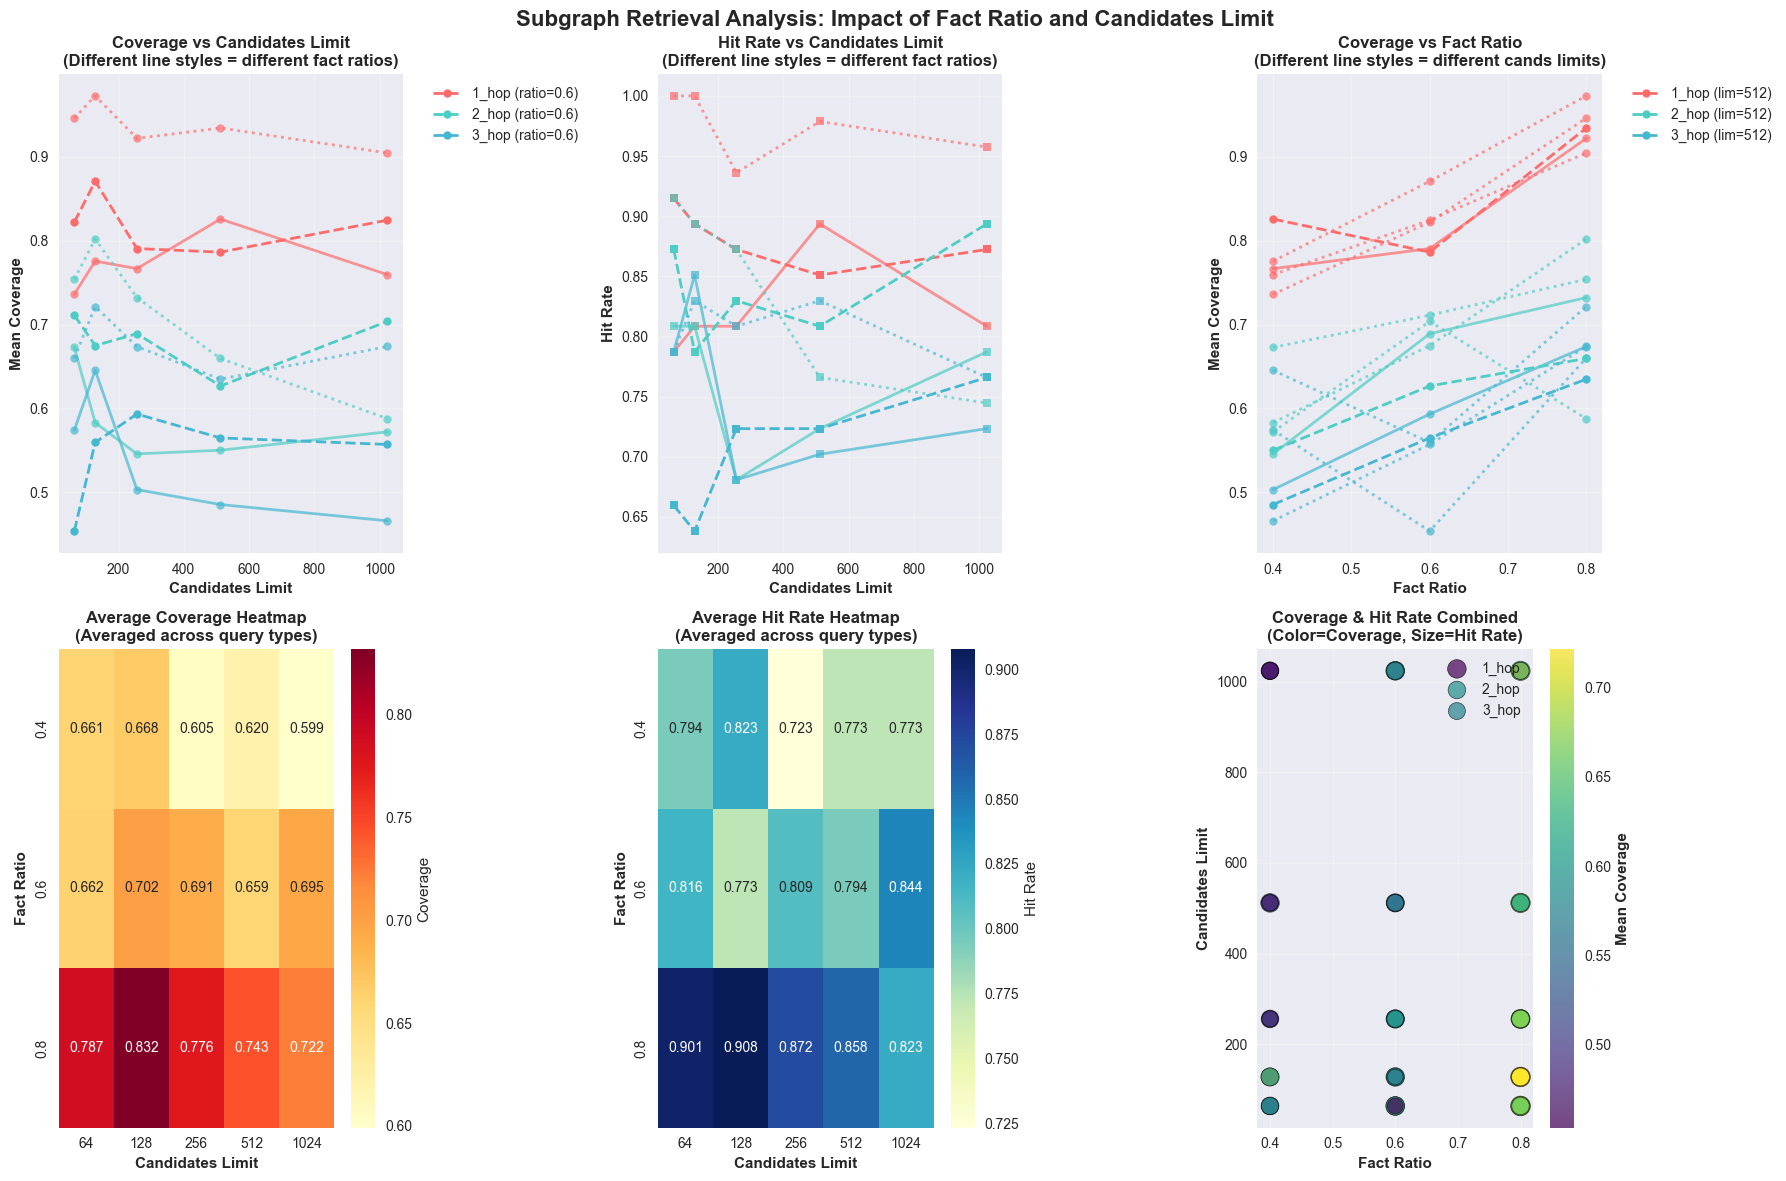

✅ Comprehensive analysis plot created successfully

📈 Creating query type comparison for coverage...
📊 Plot saved to: results/expand_subgraph/query_type_coverage_comparison.png


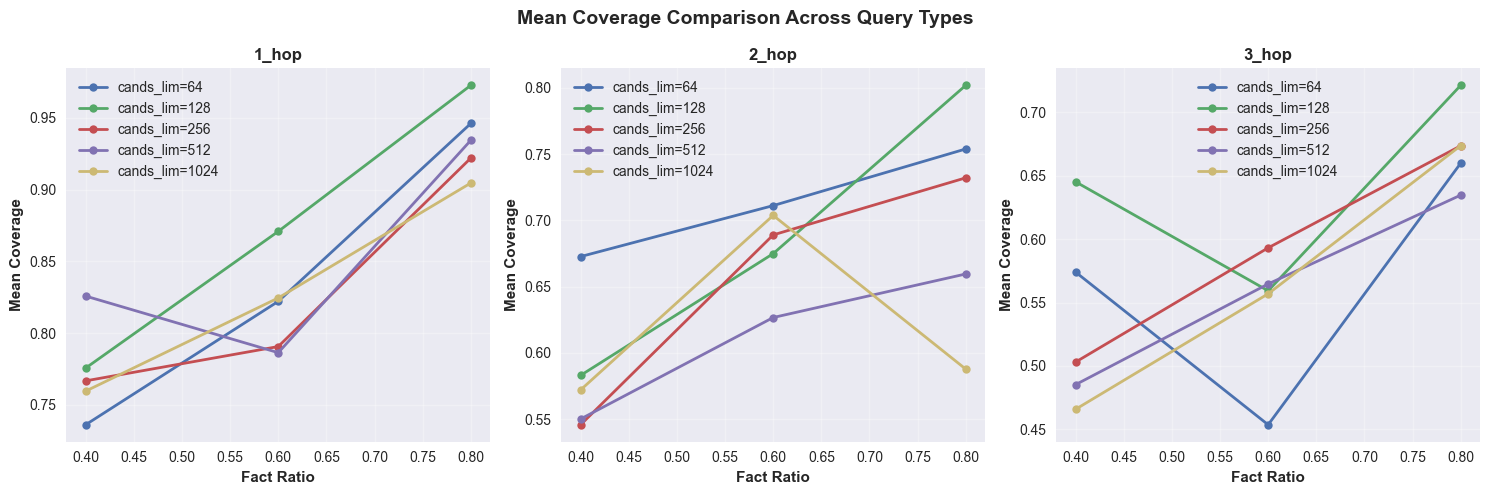

✅ Query type coverage comparison created successfully

🎯 Creating query type comparison for hit rate...
📊 Plot saved to: results/expand_subgraph/query_type_hitrate_comparison.png


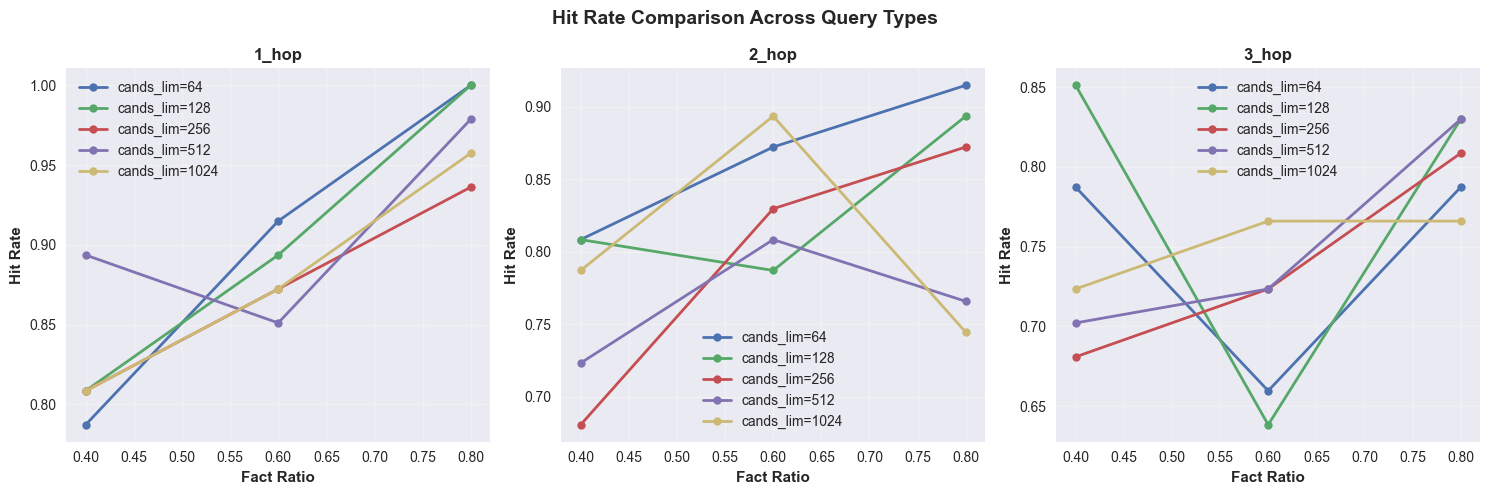

✅ Query type hit rate comparison created successfully

⚖️ Creating performance trends analysis...
📊 Plot saved to: results/expand_subgraph/performance_trends.png


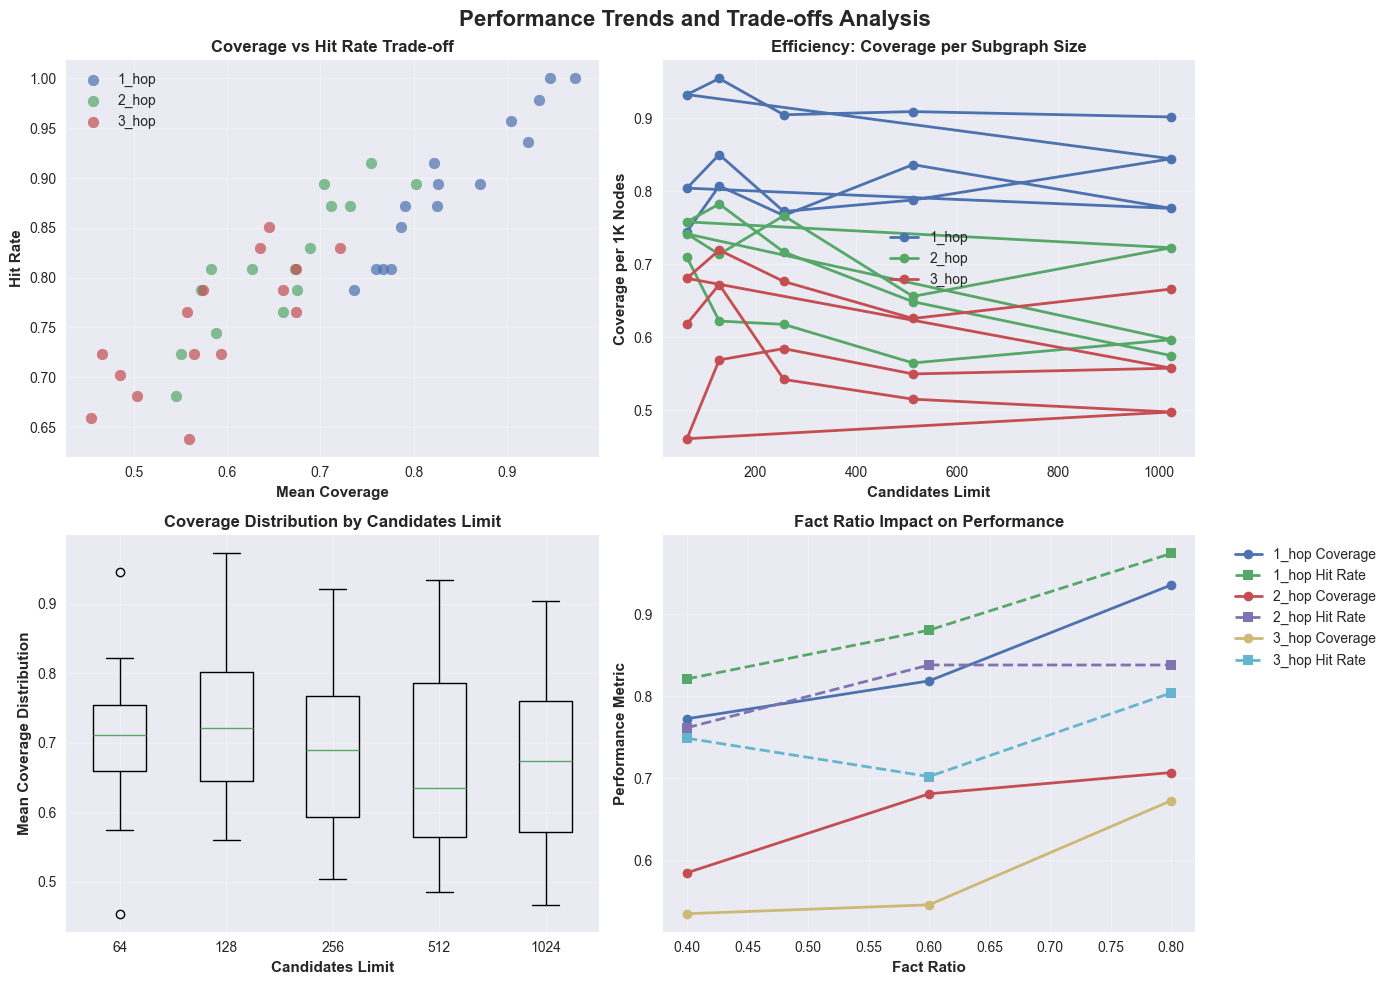

✅ Performance trends analysis created successfully

📝 GENERATING ANALYSIS REPORT...
🔍 COMPREHENSIVE SUBGRAPH RETRIEVAL ANALYSIS REPORT

📊 DATASET SUMMARY:
   • Total experiments: 45
   • Fact ratio range: 0.4 - 0.8
   • Candidates limit range: 64 - 1024
   • Query types: 1_hop, 2_hop, 3_hop

🎯 PERFORMANCE ANALYSIS:
   • Best Coverage: 0.973
     └─ Configuration: fact_ratio=0.8, cands_lim=128, query_type=1_hop
   • Best Hit Rate: 1.000
     └─ Configuration: fact_ratio=0.8, cands_lim=64, query_type=1_hop

📈 TREND ANALYSIS:
   • Candidates Limit Effect:
     └─ 64: Coverage=0.703, Hit Rate=0.837
     └─ 128: Coverage=0.734, Hit Rate=0.835
     └─ 256: Coverage=0.691, Hit Rate=0.801
     └─ 512: Coverage=0.674, Hit Rate=0.809
     └─ 1024: Coverage=0.672, Hit Rate=0.813
   • Fact Ratio Effect:
     └─ 0.4: Coverage=0.631, Hit Rate=0.777
     └─ 0.6: Coverage=0.682, Hit Rate=0.807
     └─ 0.8: Coverage=0.772, Hit Rate=0.872

🔗 QUERY COMPLEXITY ANALYSIS:
   • 1_hop:
     └─ Coverage: 0.843

,fact_ratio,cands_lim,query_type,mean_coverage,hit_rate,avg_subgraph_size,num_queries,efficiency
0,0.4,64,1_hop,0.736069,0.787234,988.340426,47,0.744752
1,0.4,64,2_hop,0.672643,0.808511,947.808511,47,0.709682
2,0.4,64,3_hop,0.574043,0.787234,928.297872,47,0.618383
3,0.4,128,1_hop,0.775583,0.808511,960.510638,47,0.807469
4,0.4,128,2_hop,0.582950,0.808511,936.872340,47,0.622230
5,0.4,128,3_hop,0.645265,0.851064,959.808511,47,0.672285
6,0.4,256,1_hop,0.766667,0.808511,999.617021,47,0.766960
7,0.4,256,2_hop,0.545670,0.680851,883.361702,47,0.617720
8,0.4,256,3_hop,0.503071,0.680851,927.744681,47,0.542252
9,0.4,512,1_hop,0.825777,0.893617,986.936170,47,0.836707


In [ ]:
from experiment_utils import run_complete_analysis

run_complete_analysis("results/expand_subgraph/cands_lim_results.csv")